# README

Train and predict type and stage classes with LSTM

* Load data from CSV files
    * inspect the data
* Dependent variables
    * convert a class vector (integers) to binary class matrix (one hot encoding)
* Train a LSTM model for type classification
    * save and restore model and weights
    * evaluation and prediction
* Train a LSTM model for stage classification
    * save and restore model and weights
    * evaluation and prediction

In [197]:
%matplotlib inline

In [281]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.models import model_from_json
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [199]:
original_features=['scalar.fx', 'scalar.fy', 'scalar.fz','scalar.tx', 'scalar.ty','scalar.tz','scalar.current','scalar.ang_vel']

# Load data

In [201]:
%%time
dfs = [pd.read_csv(filename, sep=',',header=0) for filename in glob.glob("data/*.csv")]

CPU times: user 15.1 s, sys: 0 ns, total: 15.1 s
Wall time: 15.1 s


## View the first observation

In [312]:
dfs[0].head(5)

,time,class.stage,class.success,class.type,scalar.fx,scalar.fy,scalar.fz,scalar.tx,scalar.ty,scalar.tz,...,scalar.fz_sd[0.3],scalar.tx_sd[0.3],scalar.ty_sd[0.3],scalar.tz_sd[0.3],scalar.current,scalar.ang_vel,scalar.current_sma[0.3],scalar.ang_vel_sma[0.3],scalar.current_sd[0.3],scalar.ang_vel_sd[0.3]
0,0.000000,0,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.044009,0,1,1,0.218423,-0.080284,-0.712143,-5.549292,9.641801,0.255,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.048720,0,1,1,0.218423,-0.080284,-0.712143,-5.549292,9.641801,0.255,...,0.026348,3.196264,1.804508,0.429969,0.0,0.0,0.0,0.0,0.0,0.0
3,0.054739,0,1,1,0.236574,-0.179088,-0.503643,9.798656,20.486938,2.739,...,0.026348,3.196264,1.804508,0.429969,0.0,0.0,0.0,0.0,0.0,0.0
4,0.059087,0,1,1,0.236574,-0.179088,-0.503643,9.798656,20.486938,2.739,...,0.102136,4.700885,6.458390,1.217789,0.0,0.0,0.0,0.0,0.0,0.0


In [313]:
dfs[0].tail(5)

,time,class.stage,class.success,class.type,scalar.fx,scalar.fy,scalar.fz,scalar.tx,scalar.ty,scalar.tz,...,scalar.fz_sd[0.3],scalar.tx_sd[0.3],scalar.ty_sd[0.3],scalar.tz_sd[0.3],scalar.current,scalar.ang_vel,scalar.current_sma[0.3],scalar.ang_vel_sma[0.3],scalar.current_sd[0.3],scalar.ang_vel_sd[0.3]
2079,12.602121,9,1,1,0.294390,-0.144972,0.020484,6.079564,23.921930,1.025,...,0.053050,4.629962,7.399710,0.077747,79.537117,59.137932,10.055333,67.777779,19.705233,2.401141
2080,12.612848,9,1,1,0.129503,-0.081472,0.149399,-3.026936,3.488761,0.960,...,0.054136,4.630539,7.522501,0.077810,79.537117,59.137932,10.055333,67.777779,19.705233,2.401141
2081,12.623182,9,1,1,0.251306,-0.106954,0.104298,-0.230002,20.200623,0.954,...,0.055324,4.598148,7.721436,0.077981,79.537117,59.137932,10.055333,67.777779,19.705233,2.401141
2082,12.633887,9,1,1,0.199294,-0.127574,0.125282,3.211938,10.245578,1.029,...,0.055823,4.594991,7.807427,0.078231,79.537117,59.137932,10.055333,67.777779,19.705233,2.401141
2083,12.644205,9,1,1,0.267947,-0.123256,0.048522,0.193272,21.915388,1.087,...,0.055942,4.648506,7.816956,0.078316,79.537117,59.137932,10.055333,67.777779,19.705233,2.401141


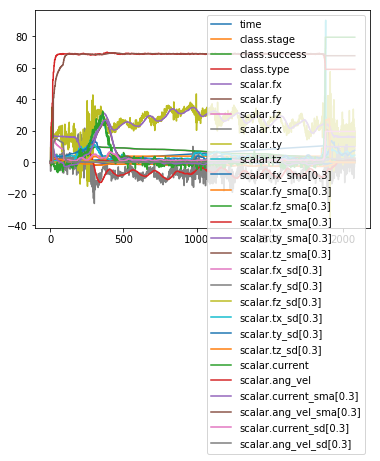

In [203]:
dfs[0].interpolate().plot()

## Some statistics

In [204]:
dfs[0].loc[:, original_features].describe()

,scalar.fx,scalar.fy,scalar.fz,scalar.tx,scalar.ty,scalar.tz,scalar.current,scalar.ang_vel
count,2084.000000,2084.000000,2084.000000,2084.000000,2084.000000,2084.000000,2084.000000,2084.000000
mean,0.113114,-1.346346,5.476660,-5.167106,24.404905,4.020081,9.706841,67.518863
std,0.486848,0.706955,3.064249,5.835924,8.036188,6.693049,23.804352,5.410341
min,-1.276666,-2.548844,-0.712143,-30.834291,-35.249496,-0.473000,-6.392606,0.000000
25%,-0.216951,-1.860305,3.613674,-8.929918,20.592451,1.134750,-0.882381,68.793106
50%,0.204268,-1.345932,5.654865,-6.276982,25.649468,2.193500,0.755794,68.965515
75%,0.423524,-0.974585,8.242234,-2.548276,29.687766,3.746000,3.287520,69.137932
max,1.649898,0.000000,10.681504,21.756088,57.659100,90.290001,79.537117,70.000000


## Get the longest and shortest sequences

In [205]:
longest_len = max(dfs, key=lambda df: df.shape[0]).shape[0]
shorted_len = min(dfs, key=lambda df: df.shape[0]).shape[0]

## Pad 0 after each sequence to match the longest

In [206]:
def post_pad(df, longest_len, pad_value=0.0):
    """pad 0 after each sequence to match the longest
    return a new dataframe"""
    df = dfs[0]
    features = list(df)
    height = longest_len - df.shape[0]
    df_pad = pd.DataFrame(pad_value, index=np.arange(height), columns=features)
    return pd.concat([df, df_pad])

In [315]:
df_full = post_pad(dfs[0], longest_len=longest_len)
df_full.head(5)

,time,class.stage,class.success,class.type,scalar.fx,scalar.fy,scalar.fz,scalar.tx,scalar.ty,scalar.tz,...,scalar.fz_sd[0.3],scalar.tx_sd[0.3],scalar.ty_sd[0.3],scalar.tz_sd[0.3],scalar.current,scalar.ang_vel,scalar.current_sma[0.3],scalar.ang_vel_sma[0.3],scalar.current_sd[0.3],scalar.ang_vel_sd[0.3]
0,0.000000,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.044009,0.0,1.0,1.0,0.218423,-0.080284,-0.712143,-5.549292,9.641801,0.255,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.048720,0.0,1.0,1.0,0.218423,-0.080284,-0.712143,-5.549292,9.641801,0.255,...,0.026348,3.196264,1.804508,0.429969,0.0,0.0,0.0,0.0,0.0,0.0
3,0.054739,0.0,1.0,1.0,0.236574,-0.179088,-0.503643,9.798656,20.486938,2.739,...,0.026348,3.196264,1.804508,0.429969,0.0,0.0,0.0,0.0,0.0,0.0
4,0.059087,0.0,1.0,1.0,0.236574,-0.179088,-0.503643,9.798656,20.486938,2.739,...,0.102136,4.700885,6.458390,1.217789,0.0,0.0,0.0,0.0,0.0,0.0


## Convert dataframe list to a ndarray of dimension N x H x W 

In [208]:
X = np.zeros((len(dfs), longest_len, len(original_features)))
for df, d_arr in zip(dfs, X):
    df_f = post_pad(df, longest_len=longest_len)
    d_arr = df_f.as_matrix(columns=original_features)

In [209]:
X.shape

(1862, 4479, 8)

## Dependent variables

### Type classification

**Note** The class starts from 0 instead of 1.

In [231]:
dependent_feature = 'class.type'
Y = np.zeros((len(dfs), 1))
offset = 1
for idx, df in enumerate(dfs):
    Y[idx] = df[dependent_feature].iloc[-1] - offset

In [232]:
num_classes = len(np.unique(Y))
print('num_classes =', num_classes)
Y=keras.utils.to_categorical(Y, num_classes=num_classes)

('num_classes =', 7)


### Stage classification
**Note** the class starts from 0 instead of 1.

In [245]:
dependent_feature = 'class.stage'
Y2 = np.zeros((len(dfs), 1))
offset = 1
for idx, df in enumerate(dfs):
    Y2[idx] = df[dependent_feature].iloc[-1] - offset

In [246]:
np.unique(Y2)

array([ 0.,  2.,  3.,  4.,  5.,  7.,  8.])

In [247]:
num_stage_classes = int(Y2.max() - Y2.min() + 1)
print('num_stage_classes =', num_stage_classes)
Y2=keras.utils.to_categorical(Y2, num_classes=num_stage_classes)

('num_stage_classes =', 9)


# Split the data to train, validation and test

* train = 60%
* validation = 20%
* test = 20%

In [248]:
x_train, x_validate, x_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])
y_train, y_validate, y_test = np.split(Y, [int(.6*len(Y)), int(.8*len(Y))])
y2_train, y2_validate, y2_test = np.split(Y2, [int(.6*len(Y2)), int(.8*len(Y2))])

In [272]:
print('x_train.shape=', x_train.shape, ' y_train.shape=', y_train.shapeape, ' y2_train.shape=', y2_train.shape)

('x_train.shape=', (1117, 4479, 8), ' y_train.shape=', (1117, 7), ' y2_train.shape=', (1117, 9))


# Train a type classification model with LSTM

In [269]:
%%time

data_dim = x_train.shape[2]
timesteps = x_train.shape[1]
num_epochs = 2
batch_size = 64

layers = [LSTM(batch_size, return_sequences=True,
               input_shape=(timesteps, data_dim)), 
         LSTM(batch_size, return_sequences=True),
         LSTM(batch_size),
         Dense(num_classes, activation='softmax')]

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential(layers)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_validate, y_validate))

Train on 1117 samples, validate on 372 samples
Epoch 1/2
1117/1117 [==============================] - 197s 176ms/step - loss: 0.9759 - acc: 0.8433 - val_loss: 0.5336 - val_acc: 0.8683
Epoch 2/2
1117/1117 [==============================] - 195s 175ms/step - loss: 0.6362 - acc: 0.8433 - val_loss: 0.5260 - val_acc: 0.8683
CPU times: user 9min 26s, sys: 0 ns, total: 9min 26s
Wall time: 6min 33s


## View training history

In [265]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

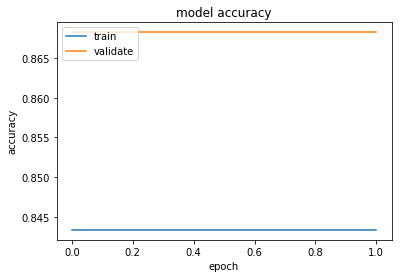

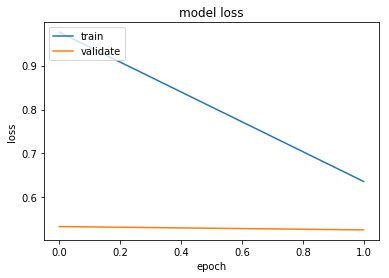

In [270]:
plot_history(history)

## Save the model
include the model and its weights

In [276]:
def save_model(model, model_filename="models/type_lstm.json", weights_file_name="models/type_lstm.h5"):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_filename, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weights_file_name)
    print("Saved the model to disk")

In [277]:
save_model(model, "models/type_lstm.json", "models/type_lstm.h5")

Saved the model to disk


## Use the saved model to predict on new data

In [283]:
def load_model(model_filename='models/type_lstm.json', weights_filename="models/type_lstm.h5"):
    # load json and create model
    json_file = open(model_filename, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_filename)
    print("Loaded the model from disk")
    
    return loaded_model

In [289]:
model = load_model('models/type_lstm.json', "models/type_lstm.h5")

Loaded the model from disk


## We need to compile the model before use it

In [292]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Evaluation

display labels for the scalar outputs

In [294]:
model.metrics_names

['loss', 'acc']

In [295]:
score = model.evaluate(x_test, y_test, batch_size=64)

373/373 [==============================] - 13s 35ms/step


In [296]:
score

[0.66744910600038376, 0.82841823631572975]

## Predict

**Remember** The classes are 0 to 6 instead of 1 to 7.

In [297]:
%%time
y_hat = model.predict(x_test)

CPU times: user 25.3 s, sys: 0 ns, total: 25.3 s
Wall time: 25.1 s


### Prediction results are the probability of each class

In [298]:
y_hat.shape

(373, 7)

In [299]:
y_hat

array([[ 0.89689052,  0.06203213,  0.01903552, ...,  0.00295608,
         0.00427565,  0.00620248],
       [ 0.89689052,  0.06203213,  0.01903552, ...,  0.00295608,
         0.00427565,  0.00620248],
       [ 0.89689052,  0.06203213,  0.01903552, ...,  0.00295608,
         0.00427565,  0.00620248],
       ..., 
       [ 0.89689052,  0.06203213,  0.01903552, ...,  0.00295608,
         0.00427565,  0.00620248],
       [ 0.89689052,  0.06203213,  0.01903552, ...,  0.00295608,
         0.00427565,  0.00620248],
       [ 0.89689052,  0.06203213,  0.01903552, ...,  0.00295608,
         0.00427565,  0.00620248]], dtype=float32)

# Train a stage classification model with LSTM

In [251]:
%%time

data_dim = x_train.shape[2]
timesteps = x_train.shape[1]
num_epochs = 2
batch_size = 64

layers = [LSTM(batch_size, return_sequences=True,
               input_shape=(timesteps, data_dim)), 
         LSTM(batch_size, return_sequences=True),
         LSTM(batch_size),
         Dense(num_stage_classes, activation='softmax')]

# expected input data shape: (batch_size, timesteps, data_dim)
model2 = Sequential(layers)

model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history2 = model2.fit(x_train, y2_train,
          batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_validate, y2_validate))

Train on 1117 samples, validate on 372 samples
Epoch 1/2
1117/1117 [==============================] - 194s 174ms/step - loss: 0.9458 - acc: 0.8138 - val_loss: 0.4883 - val_acc: 0.8817
Epoch 2/2
1117/1117 [==============================] - 194s 173ms/step - loss: 0.5631 - acc: 0.8630 - val_loss: 0.4934 - val_acc: 0.8817
CPU times: user 9min 14s, sys: 0 ns, total: 9min 14s
Wall time: 6min 29s


## View training history

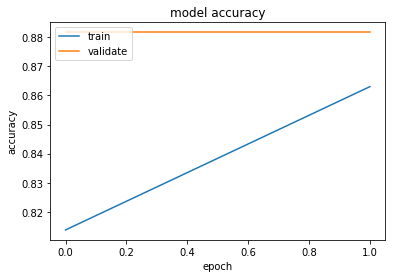

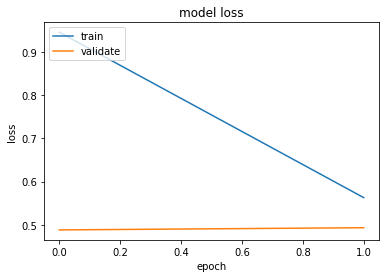

In [267]:
plot_history(history2)

## Save the model
include the model and its weights

In [300]:
save_model(model2, "models/stage_lstm.json", "models/stage_lstm.h5")

Saved the model to disk


## Use the saved model to predict on new data

In [301]:
model2 = load_model('models/stage_lstm.json', "models/stage_lstm.h5")

Loaded the model from disk


## We need to compile the model before use it

In [302]:
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Evaluation

display labels for the scalar outputs

In [306]:
model2.metrics_names

['loss', 'acc']

In [307]:
score = model2.evaluate(x_test, y2_test, batch_size=64)

373/373 [==============================] - 13s 35ms/step


In [308]:
score

[0.59648381864736932, 0.84450402512307465]

## Predict

**Remember** The classes are 0 to 6 instead of 1 to 7.

In [309]:
%%time
y2_hat = model2.predict(x_test)

CPU times: user 25.7 s, sys: 0 ns, total: 25.7 s
Wall time: 25.5 s


### Prediction results are the probability of each class

In [310]:
y2_hat.shape

(373, 9)

In [311]:
y2_hat

array([[ 0.01365919,  0.00189228,  0.16177613, ...,  0.00223439,
         0.01046928,  0.77538913],
       [ 0.01365919,  0.00189228,  0.16177613, ...,  0.00223439,
         0.01046928,  0.77538913],
       [ 0.01365919,  0.00189228,  0.16177613, ...,  0.00223439,
         0.01046928,  0.77538913],
       ..., 
       [ 0.01365919,  0.00189228,  0.16177613, ...,  0.00223439,
         0.01046928,  0.77538913],
       [ 0.01365919,  0.00189228,  0.16177613, ...,  0.00223439,
         0.01046928,  0.77538913],
       [ 0.01365919,  0.00189228,  0.16177613, ...,  0.00223439,
         0.01046928,  0.77538913]], dtype=float32)